In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
from data_loader import Loader
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from hutils import *
import os

C:\Users\jaabi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def tkpt(img, bbox, kpt, img_size = 229):
    x1,y1,x2,y2 = list(map(int, bbox))
    Transform = A.Compose([
        A.Crop(x_min = x1, y_min = y1, x_max = x2, y_max = y2, always_apply=True, p=1.0),
        A.Resize(img_size, img_size),
    ], 
    keypoint_params = A.KeypointParams(format="xy", remove_invisible = False)
    )
    
    transformed = Transform(
          image=img,
          keypoints=kpt,
        )
    kpts = transformed['keypoints']
    return np.array(kpts)
    
def timage(img, kpts, bbox, IMG_SIZE = 299):
    x1,y1,x2,y2 = list(map(int, bbox))
    transformer = A.Compose([
        A.Crop(x_min = x1, y_min = y1, x_max = x2, y_max = y2, always_apply=True, p=1.0), 
        A.Resize(IMG_SIZE, IMG_SIZE)], keypoint_params = A.KeypointParams(format="xy", remove_invisible = False))
    transformed = transformer(image = img, keypoints=kpts)
    img = torch.from_numpy(transformed['image'].astype(np.float32)).permute(-1, 0, 1) 
    img = torch.unsqueeze(img, dim = 0)
    kpts = transformed['keypoints']
    return img, np.array(kpts).astype(np.uint32)

def predict_(model, img, kpts, bbox, IMG_SIZE = 299, device = False):
    img, kpts = timage(img, kpts, bbox, IMG_SIZE)          
    model.eval()
    with torch.no_grad():
        preds = torch.squeeze(model(img.to('cuda' if device else 'cpu')))
    
    if device:
        img = img.cpu()
        preds = preds.cpu()
    return torch.squeeze(img.detach()).permute(1,-1,0).numpy().copy(), (preds.reshape(-1, 2).numpy() * IMG_SIZE).astype(np.uint32), kpts

In [3]:
def get_rand_ib(test_df):
    sdf = test_df.sample()
    ipath = sdf.images.values[0]
    ab_path = sdf.abs_path.values[0]
    iid = ipath.split('/')[-1].split('_')[0]
    jpath = os.path.join(ab_path, f'{iid}_joint_pos.txt')
    joints = get_joints(jpath)
    kpts = convert_3d_to_2d(joints).astype(int)
    image = plt.imread(ipath)
    h,w,c = image.shape
    bbox = get_crop_uv(kpts, hw = (h, w), thresh = 30)
    
    return image, kpts, bbox

def RMSE(true, preds):
    return np.sqrt(np.mean(np.square(true - preds)))

def compare_pred(model, image, tkpts, box, device = False):
    img = image.copy()
    oimg = img.copy()
    img, kpts = predict_(model, img, kpts, box, device = device)
    nimg = img.copy()
    plt.subplot(1,2,1)
    plt.imshow(renderPose(img, kpts))
    plt.title('predicted')
    plt.axis(False);

    plt.subplot(1, 2, 2)
    tkpts = tkpt(oimg,box, tkpts).astype(int)
    plt.imshow(renderPose(nimg, tkpts))
    plt.title('true')
    plt.axis(False)
    print(f'RMSE : {round(RMSE(tkpts, kpts), 3)}')
    
from tqdm import tqdm

def pred_batches(model, loader, im_size, num_batches = 1):
    tkpts = []
    pkpts = []
    iterr = 0
    for batch in loader:
        if iterr >= num_batches:
            break
        img, kpts = batch                 
        model.eval()
        with torch.no_grad():
            kpts = kpts.detach().numpy()
            preds = model(img).detach().numpy()
            for i in tqdm(range(preds.shape[0])):
                tkpts.append(kpts[i])
                pkpts.append(preds[i])
        iterr += 1
                
    true = np.array(tkpts)
    preds = np.array(pkpts)
    print(true.shape, preds.shape)
    print(f'Total RMSE : {round(RMSE(true, preds) * im_size, 2)}')
    root_lbls = ['center', 'thumb', 'index', 'middle', 'ring', 'pinky']
    st = 0
    for i in range(6):
        curr_finger = root_lbls[i]
        ed = st + 4
        strue = true[:, st:ed]
        spreds = preds[:, st:ed]
        print(f'{curr_finger} finger RMSE : {round(RMSE(strue, spreds) * im_size, 2)}')
        st = ed

In [4]:
df = pd.read_csv('synthetic_hand_test.csv', nrows = 5000)
df.head()

,images,imageID,abs_path,labels
0,SynthHands_Release/male_noobject/seq04/cam05/0...,445,SynthHands_Release/male_noobject/seq04/cam05/01,male_noobject
1,SynthHands_Release/female_noobject/seq07/cam05...,451,SynthHands_Release/female_noobject/seq07/cam05/01,female_noobject
2,SynthHands_Release/male_object/seq03/cam04/02/...,190,SynthHands_Release/male_object/seq03/cam04/02,male_object
3,SynthHands_Release/female_noobject/seq01/cam03...,102,SynthHands_Release/female_noobject/seq01/cam03/03,female_noobject
4,SynthHands_Release/male_object/seq01/cam02/02/...,369,SynthHands_Release/male_object/seq01/cam02/02,male_object


In [16]:
from syn_hnet import load_model, HNet
import torchvision.models as models
from handnet import HandNet
from Mobnet import MobNet

def load_from_ckpt(ckpt, net_type):
    mpath = os.path.join('models', ckpt)
    if net_type == 'hnet':
        model = HNet.load_from_checkpoint(mpath)
    elif net_type == 'mnet':
        model = MobNet.load_from_checkpoint(mpath)
    else:
        base_model = models.resnet50()
        num_features = 2048
        img_size = (224, 224)
        model = HandNet(None, 42, img_size, base_model = base_model, num_features = num_features)
        model.load_state_dict(torch.load(mpath))
    return model

In [8]:
mname = 'syn_hnet.pt-epoch=02-val_loss=0.0334.ckpt'
model = load_from_ckpt(mname, 'mnet')

# mname = os.path.join('models', 'mnet_tr.pt')
# model = torch.load(mname)

C:\Users\jaabi\anaconda3\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.2, which is newer than your current Lightning version: v2.0.9.post0
  rank_zero_warn(


In [19]:
device = torch.cuda.is_available()
# model = load_model('syn_hnet.pt')
if device:
    model.to('cuda')
    print('Accelarator: GPU')
else:
    print('Accelarator: CPU')

Accelarator: GPU


In [10]:
def compare_preds(model, ikb = None, device = False):
    if ikb is None:
        ikb = get_rand_ib(df)
    oimg, okpts, obox = ikb
    cimg, pkpts, ckpts = predict_(model, oimg.copy(), okpts, obox, device = device)
    
    plt.subplot(1, 2, 1)
    plt.imshow(renderPose(cimg.copy(), pkpts))
    plt.title('predicted')
    plt.axis(False)
    
    plt.subplot(1, 2, 2)
    plt.imshow(renderPose(cimg.copy(), ckpts))
    plt.title('true')
    plt.axis(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


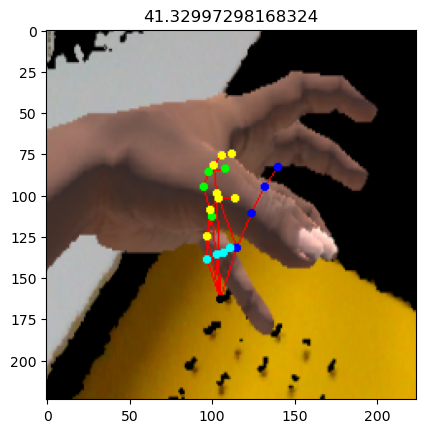

In [12]:
img, kpts, box = get_rand_ib(df)
img, pkpts, tkpts = predict_(model, img, kpts, box, device = device, IMG_SIZE = 224)
plt.imshow(renderPose(img, pkpts));
plt.title(RMSE(tkpts, pkpts));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


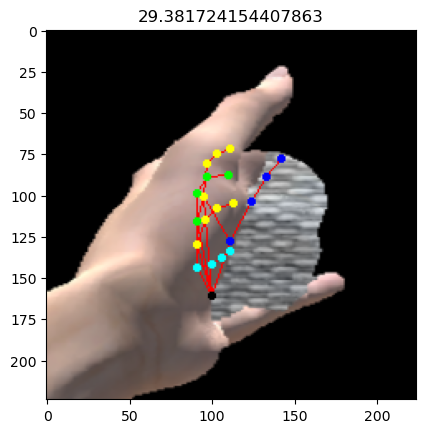

In [20]:
img, kpts, box = get_rand_ib(df)
img, pkpts, tkpts = predict_(model, img, kpts, box, device = device, IMG_SIZE = 224)
plt.imshow(renderPose(img, pkpts));
plt.title(RMSE(tkpts, pkpts));

### Resnet 

In [17]:
mname = 'resnet_ptr.pt'
model = load_from_ckpt(mname, 'resnet')
model

HandNet(
  (criterion): SmoothL1Loss()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


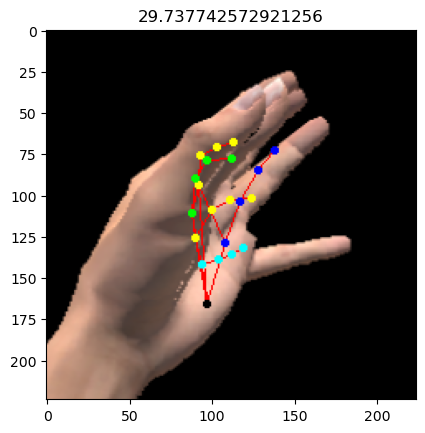

In [20]:
img, kpts, box = get_rand_ib(df)
img, pkpts, tkpts = predict_(model, img, kpts, box, device = device, IMG_SIZE = 224)
plt.imshow(renderPose(img, pkpts));
plt.title(RMSE(tkpts, pkpts));

In [22]:
(40 * 7) / 60

4.666666666666667